In [24]:
!pip install torch --index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://download.pytorch.org/whl/cpu


In [25]:
import torch

device = torch.device('cpu')
print('Utilisation de :', device)

Utilisation de : cpu


# **Prédiction de Flux Bitcoin avec Graph Neural Networks Temporels**

## **1.Importation des bibliothèques et chargement des données**

In [26]:
import pandas as pd

# Charger les fichiers
#features : caractéristiques des transactions
#edglist : liste des arêtes (transactions)
# URL vers les fichiers CSV hébergés sur GitHub
url_features_df = 'https://raw.githubusercontent.com/Ichraf-MOUELHI/Prediction-flow-Bitcoin_GNNT/refs/heads/main/bitc_features.csv'
url_edgelist_df = 'https://raw.githubusercontent.com/Ichraf-MOUELHI/Prediction-flow-Bitcoin_GNNT/refs/heads/main/bitc_edgelist.csv'
url_classes_df = 'https://raw.githubusercontent.com/Ichraf-MOUELHI/Prediction-flow-Bitcoin_GNNT/refs/heads/main/bitc_classes.csv'


# Chargement des fichiers directement depuis GitHub
features_df = pd.read_csv(url_features_df, header=None)
edgelist_df = pd.read_csv(url_edgelist_df, names=['tx1', 'tx2'])
classes_df = pd.read_csv(url_classes_df)



<ipython-input-26-d235f72a32ec>:13: DtypeWarning:

Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166) have mixed types. Specify dtype option on import or set low_memory=False.



In [27]:
features_df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,ID,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f156,f157,f158,f159,f160,f161,f162,f163,f164,f165
1,312135211,2,-0.1670348809486676,-0.1846675514329143,-1.2013688016765636,-0.1219695997591005,-0.0438745479173489,-0.1130020092847624,-0.0615837940730322,-0.157559745871127,...,-0.4052215723429499,-0.4559278437408004,-0.979073766855825,-0.9785560465643004,-0.098888736679456,-0.0874901561101501,-0.0846742330262522,-0.1405970785066562,1.5196996159005878,1.5213994830935649
2,310757278,2,0.4533573103448167,-0.1846675514329143,-1.2013688016765636,-0.1219695997591005,-0.0438745479173489,-0.1130020092847624,-0.0615837940730322,0.4771929443478788,...,-0.5696264282858337,-0.6073063273357365,-0.979073766855825,-0.9785560465643004,0.0182794000374458,-0.0874901561101501,-0.1311553038955873,-0.0975235937715251,-0.1206134067031157,-0.1197924596125166
3,9458805,4,-0.1588290522631055,-0.1296825753656461,1.018601901343969,0.1781804337333897,0.0950756293330667,0.2224469449816331,-0.0615837940730322,-0.1635649454917969,...,0.8054173222931026,1.7257444684399217,0.6328120045277644,0.6555395829868258,-0.098888736679456,0.0470810477654827,0.0302321386435384,-0.0496641662880461,-0.5170473659853385,-0.2178724377790862
4,94708789,4,-0.1569894268301511,-0.1846675514329143,-1.2013688016765636,-0.1219695997591005,-0.0438745479173489,-0.1130020092847624,-0.0615837940730322,-0.1472817650781942,...,-0.1063036524467977,-0.216245244715485,-0.979073766855825,-0.9785560465643004,0.0182794000374458,-0.0874901561101501,-0.1311553038955873,-0.0975235937715251,-0.1206134067031157,-0.1197924596125166


In [28]:
edgelist_df.head(5)

,tx1,tx2
0,txId1,txId2
1,230425980,5530458
2,232022460,232438397
3,230460314,230459870
4,230333930,230595899


In [29]:
classes_df.head(5)

,txId,class
0,230425980,unknown
1,5530458,unknown
2,232022460,unknown
3,232438397,2
4,230460314,unknown


In [30]:
# Séparer les colonnes
features_df.columns = ['txId', 'time_step'] + [f'feature_{i}' for i in range(1, 166)]  # Changed range to (1, 166)

# Supprimer la première ligne du features_df
features_df = features_df.iloc[1:]

# Fusionner les classes avec les features
features_df = features_df.merge(classes_df, on='txId', how='left')

# Vérification
print("Features shape:", features_df.shape)
print("Edgelist shape:", edgelist_df.shape)
print("Extrait des données fusionnées:")
display(features_df.head())

Features shape: (5937, 168)
Edgelist shape: (234356, 2)
Extrait des données fusionnées:


,txId,time_step,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_157,feature_158,feature_159,feature_160,feature_161,feature_162,feature_163,feature_164,feature_165,class
0,312135211,2,-0.1670348809486676,-0.1846675514329143,-1.2013688016765636,-0.1219695997591005,-0.0438745479173489,-0.1130020092847624,-0.0615837940730322,-0.157559745871127,...,-0.4559278437408004,-0.979073766855825,-0.9785560465643004,-0.098888736679456,-0.0874901561101501,-0.0846742330262522,-0.1405970785066562,1.5196996159005878,1.5213994830935649,NaN
1,310757278,2,0.4533573103448167,-0.1846675514329143,-1.2013688016765636,-0.1219695997591005,-0.0438745479173489,-0.1130020092847624,-0.0615837940730322,0.4771929443478788,...,-0.6073063273357365,-0.979073766855825,-0.9785560465643004,0.0182794000374458,-0.0874901561101501,-0.1311553038955873,-0.0975235937715251,-0.1206134067031157,-0.1197924596125166,NaN
2,9458805,4,-0.1588290522631055,-0.1296825753656461,1.018601901343969,0.1781804337333897,0.0950756293330667,0.2224469449816331,-0.0615837940730322,-0.1635649454917969,...,1.7257444684399217,0.6328120045277644,0.6555395829868258,-0.098888736679456,0.0470810477654827,0.0302321386435384,-0.0496641662880461,-0.5170473659853385,-0.2178724377790862,NaN
3,94708789,4,-0.1569894268301511,-0.1846675514329143,-1.2013688016765636,-0.1219695997591005,-0.0438745479173489,-0.1130020092847624,-0.0615837940730322,-0.1472817650781942,...,-0.216245244715485,-0.979073766855825,-0.9785560465643004,0.0182794000374458,-0.0874901561101501,-0.1311553038955873,-0.0975235937715251,-0.1206134067031157,-0.1197924596125166,NaN
4,87627020,4,-0.1303239594683176,-0.1846675514329143,-1.2013688016765636,-0.1219695997591005,-0.0438745479173489,-0.1130020092847624,-0.0615837940730322,-0.1199990600709291,...,-0.5631542696205468,-0.979073766855825,-0.9785560465643004,-0.098888736679456,-0.0874901561101501,-0.0846742330262522,-0.1405970785066562,1.5196996159005878,1.5213994830935649,NaN


In [31]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from datetime import datetime
import torch
from IPython.display import display, clear_output
import time

## **2.Construction du graphe dirigé**

In [32]:
G = nx.from_pandas_edgelist(edgelist_df, source='tx1', target='tx2', create_using=nx.DiGraph())

# Ajout des features de noeuds si disponibles
features_df.set_index('txId', inplace=False)
for node in G.nodes():
    if node in features_df.index:
        G.nodes[node]['features'] = features_df.loc[node].values[1:]

## **3.Visualisation d’un sous-graphe**

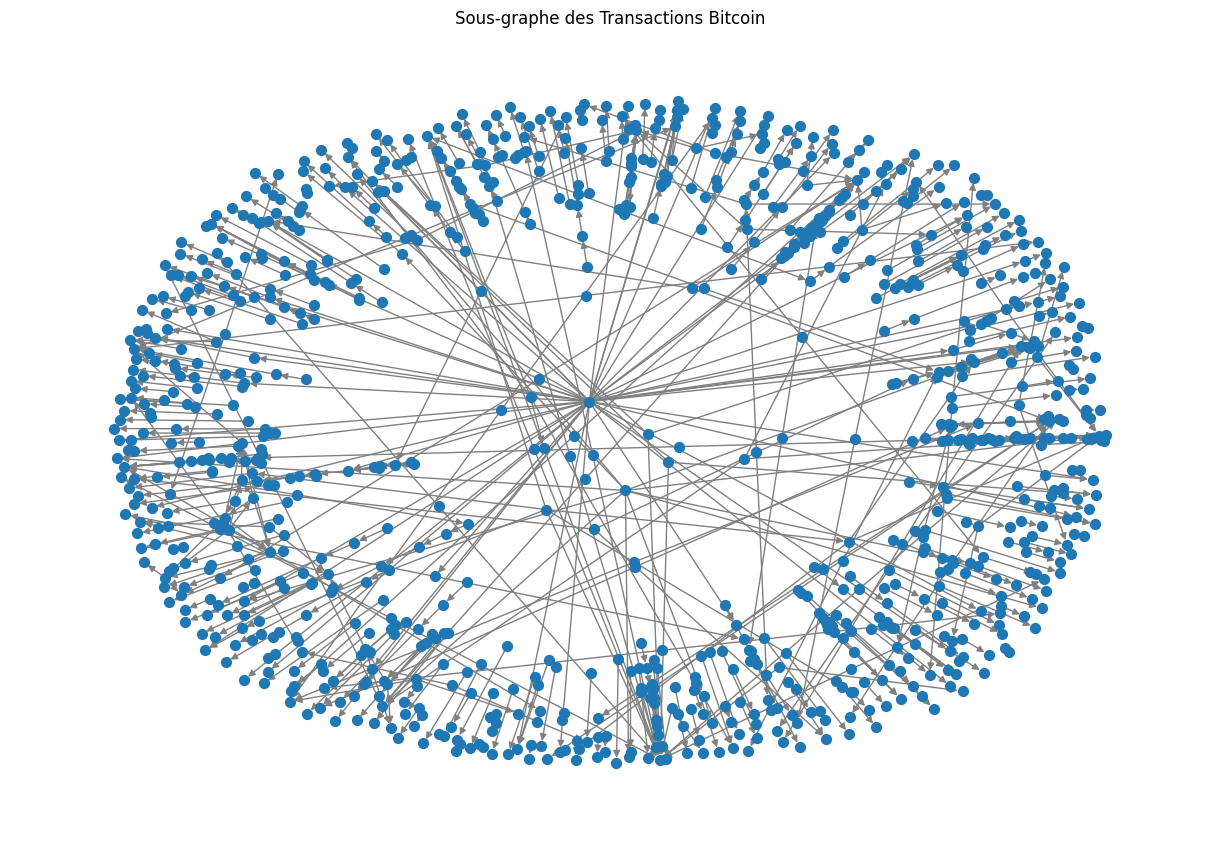

In [33]:
# Visualiser un sous-graphe avec les 1000 premiers nœuds
subgraph_nodes = list(G.nodes)[:1000]
subgraph = G.subgraph(subgraph_nodes)

plt.figure(figsize=(12, 8))
nx.draw(subgraph, with_labels=False, node_size=50, edge_color='gray')
plt.title("Sous-graphe des Transactions Bitcoin")
plt.show()

In [34]:
import plotly.graph_objects as go
import networkx as nx

# Extraire un sous-graphe avec les 1000 premiers nœuds
subgraph = G.subgraph(list(G.nodes)[:1000])
pos = nx.spring_layout(subgraph, seed=42)

# Coordonnées des arêtes
edges = go.Scatter(
    x=[pos[u][0] for u, v in subgraph.edges()] + [pos[v][0] for u, v in subgraph.edges()],
    y=[pos[u][1] for u, v in subgraph.edges()] + [pos[v][1] for u, v in subgraph.edges()],
    mode='lines',
    line=dict(width=0.5, color='gray'),
    hoverinfo='none'
)

# Coordonnées des nœuds
nodes = go.Scatter(
    x=[pos[n][0] for n in subgraph.nodes()],
    y=[pos[n][1] for n in subgraph.nodes()],
    mode='markers',
    marker=dict(
        size=5,
        color=[len(list(subgraph.adj[n])) for n in subgraph.nodes()],  # degré -> Les couleurs des nœuds représentent le degré (nombre de connexions)
        colorscale='YlGnBu',
        showscale=True,
        colorbar=dict(title='Degré')
    ),
    text=[f'Nœud {n}' for n in subgraph.nodes()],
    hoverinfo='text'
)

# Affichage interactif
fig = go.Figure(data=[edges, nodes])
fig.update_layout(
    title='Sous-graphe Bitcoin (1000 nœuds)',
    width=1200,
    height=800,
    showlegend=False,
    hovermode='closest',
    margin=dict(t=40, b=20, l=20, r=20),
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(showgrid=False, zeroline=False)
)
fig.show()


# **Résultats**
Le sous-graphe du réseau de transactions Bitcoin, ici limité aux 1000 premiers nœuds. Les sommets (nœuds) correspondent à des adresses ou des entités, et les arêtes (liens) représentent des transactions.
La densité du graph peut signifier que beaucoup d'entités échangent entre elles. Cela peut représenter une période active ou un ensemble d'acteurs très connectés.
Les couleurs des nœuds représentent leur degré (nombre de connexions). Le bleu foncé indique un degré élevé, le jaune clair un degré faible.
Le réseau n’est pas clairement modulaire ici (peu de clusters nets visibles). Cela suggère un graphe fortement interconnecté, sans communautés clairement séparées.
Dans cet échantillon le noeud central en (bleu profond) : représente de nombreux liens sortants ou entrants → potentiellement des hubs comme des exchanges ou gros wallets.

# **Hypothèse**
Ce hub pourrai représenter des services centraux : plateformes, mineurs, mixing services.

Une analyse temporelle pourrait montrer comment ces connexions évoluent dans le temps (avec des snapshots ou animation par timestamp).

In [35]:
import networkx as nx
import plotly.graph_objects as go

# Assure-toi que ton sous-graphe est défini
undirected_G = subgraph.to_undirected()

# Détection des communautés avec Label Propagation
communities = nx.algorithms.community.label_propagation_communities(undirected_G)

# Création du dictionnaire de partition
partition = {node: i for i, com in enumerate(communities) for node in com}

# Positionnement des nœuds
pos = nx.spring_layout(undirected_G, seed=42)

# Construction des nœuds
node_x, node_y, node_color = [], [], []
for node in undirected_G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_color.append(partition.get(node, 0))

# Construction des arêtes
edge_x, edge_y = [], []
for u, v in undirected_G.edges():
    x0, y0 = pos[u]
    x1, y1 = pos[v]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]

# Tracé interactif
fig = go.Figure()

# Arêtes
fig.add_trace(go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='gray'),
    hoverinfo='none',
    mode='lines'))

# Nœuds
fig.add_trace(go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    marker=dict(size=5, color=node_color, colorscale='Viridis', showscale=True),
    hoverinfo='text',
    text=[f"Node {n} — Community {partition[n]}" for n in undirected_G.nodes()]))

fig.update_layout(
    title='Visualisation Interactive des Communautés (Label Propagation)',
    showlegend=False,
    width=1000, height=800,
    margin=dict(l=0, r=0, b=0, t=30),
    hovermode='closest'
)

fig.show()


# **Description du graph**
-> Chaque nœud représente une entité (adresse ou wallet) dans le réseau Bitcoin.

-> Chaque couleur indique l'appartenance à une communauté spécifique détectée par l'algorithme de Label Propagation.

-> Les arêtes (lignes grises) représentent des transactions (liens) entre les nœuds.

Structure centrale dense : Le centre du graphe contient un groupe dense de nœuds fortement connectés.

Ces communautés centrales pourraient correspondre à des entités très actives comme des plateformes d'échange, ou clusters de bots.

Anneaux périphériques épars : En périphérie, on observe des petits amas peu connectés.
-> Cela reflète des comportements sporadiques ou isolés — typique d’utilisateurs individuels ou d'entités à usage unique.

Nombre élevé de communautés : Le graphique montre un nombre important de couleurs, ce qui signifie que le graphe est fragmenté en de nombreuses communautés.

**=> Cela est cohérent avec le fait que le réseau Bitcoin contient une très grande variété d’entités, souvent peu connectées entre elles.**

# **Hypothèses**
Le graphe montre une communauté principale dense avec de multiples sous-groupes relativement déconnectés.

Ceci suggère :

- Une hiérarchie dans les interactions (acteurs centraux et satellites).

- Une fragmentation naturelle des transactions entre différentes catégories d’utilisateurs.

- Le fait que certaines communautés soient complètement isolées indique l'existence de clusters indépendants du reste du réseau.

In [36]:

# --- Calcul des centralités (Degree, Betweenness, PageRank) ---
import pandas as pd
import networkx as nx

# Vérification du sous-graphe
if 'subgraph' in globals():
    degree_centrality = nx.degree_centrality(subgraph)
    betweenness_centrality = nx.betweenness_centrality(subgraph)
    pagerank = nx.pagerank(subgraph)

    centrality_df = pd.DataFrame({
        'Node': list(degree_centrality.keys()),
        'Degree': list(degree_centrality.values()),
        'Betweenness': list(betweenness_centrality.values()),
        'PageRank': list(pagerank.values())
    }).sort_values(by="PageRank", ascending=False)

    display(centrality_df.head(10))
else:
    print("Le sous-graphe 'subgraph' n'existe pas.")


,Node,Degree,Betweenness,PageRank
511,2758467,0.026026,0.000000,0.016001
885,232438397,0.023023,0.000000,0.015620
652,2881273,0.022022,0.000000,0.009642
488,2880930,0.008008,0.000000,0.007354
958,2717498,0.007007,0.000000,0.007344
922,230658142,0.015015,0.000000,0.007012
140,232029206,0.012012,0.000000,0.006803
215,2881274,0.013013,0.000000,0.006342
148,27405707,0.003003,0.000000,0.004972
867,230521273,0.004004,0.000013,0.004721


# **Résultat du tableau**
- Node	: ID du nœud (adresse) dans le graphe.

- Degree : Centralité de degré (normalisée) : combien de connexions a ce nœud.

- Betweenness	Centralité d’intermédiarité : à quel point ce nœud est sur le chemin entre d'autres.

- PageRank	Importance globale dans le réseau

In [37]:
import plotly.express as px
# Données de centralité extraites
centrality_data = {
    "Node": [2758467, 232438397, 2881273, 2880930, 2717498, 230658142, 232029206, 2881274, 27405707, 230521273],
    "Degree": [0.026026, 0.023023, 0.022022, 0.008008, 0.007007, 0.015015, 0.012012, 0.013013, 0.003003, 0.004004],
    "Betweenness": [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.000013],
    "PageRank": [0.016001, 0.015620, 0.009642, 0.007354, 0.007344, 0.007012, 0.006803, 0.006342, 0.004972, 0.004721]
}

df_centrality = pd.DataFrame(centrality_data)

# Visualisation interactive des nœuds centraux (hubs)
fig = px.scatter(
    df_centrality,
    x="Degree",
    y="PageRank",
    size="PageRank",
    color="Degree",
    hover_name="Node",
    title="Visualisation Interactive des Nœuds Importants (Hubs)",
    labels={"Degree": "Centralité de Degré", "PageRank": "PageRank"},
    width=900,
    height=600
)

fig.update_traces(marker=dict(sizemode='area', line=dict(width=1, color='DarkSlateGrey')))
fig.show()


# **Interprétation**
- Axe X (Centralité de Degré): Représente la proportion de connexions qu’un nœud a avec d'autres. -> Plus la valeur est élevée, plus le nœud interagit avec beaucoup d'autres nœuds.

- Axe Y (PageRank) : Représente l’importance d’un nœud dans le graphe, prenant en compte non seulement le nombre de connexions, mais aussi la qualité (importance) des nœuds connectés.

Les nœuds en haut à droite du graphique (ex. les deux bulles les plus grandes) sont : -> Très bien connectés (degré élevé). Connectés à d’autres nœuds eux-mêmes importants (PageRank élevé) **=➤ Ce sont des hubs majeurs du réseau Bitcoin : ils peuvent être des agrégateurs de transactions ou des services connus.**

Les bulles plus petites et vers le bas ont : Moins de connexions et/ou connexions vers des nœuds peu influents.



In [38]:
!pip install torch_geometric

In [39]:
edgelist_df.head(5)

,tx1,tx2
0,txId1,txId2
1,230425980,5530458
2,232022460,232438397
3,230460314,230459870
4,230333930,230595899


In [40]:
features_df.head(5)

,txId,time_step,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_157,feature_158,feature_159,feature_160,feature_161,feature_162,feature_163,feature_164,feature_165,class
0,312135211,2,-0.1670348809486676,-0.1846675514329143,-1.2013688016765636,-0.1219695997591005,-0.0438745479173489,-0.1130020092847624,-0.0615837940730322,-0.157559745871127,...,-0.4559278437408004,-0.979073766855825,-0.9785560465643004,-0.098888736679456,-0.0874901561101501,-0.0846742330262522,-0.1405970785066562,1.5196996159005878,1.5213994830935649,NaN
1,310757278,2,0.4533573103448167,-0.1846675514329143,-1.2013688016765636,-0.1219695997591005,-0.0438745479173489,-0.1130020092847624,-0.0615837940730322,0.4771929443478788,...,-0.6073063273357365,-0.979073766855825,-0.9785560465643004,0.0182794000374458,-0.0874901561101501,-0.1311553038955873,-0.0975235937715251,-0.1206134067031157,-0.1197924596125166,NaN
2,9458805,4,-0.1588290522631055,-0.1296825753656461,1.018601901343969,0.1781804337333897,0.0950756293330667,0.2224469449816331,-0.0615837940730322,-0.1635649454917969,...,1.7257444684399217,0.6328120045277644,0.6555395829868258,-0.098888736679456,0.0470810477654827,0.0302321386435384,-0.0496641662880461,-0.5170473659853385,-0.2178724377790862,NaN
3,94708789,4,-0.1569894268301511,-0.1846675514329143,-1.2013688016765636,-0.1219695997591005,-0.0438745479173489,-0.1130020092847624,-0.0615837940730322,-0.1472817650781942,...,-0.216245244715485,-0.979073766855825,-0.9785560465643004,0.0182794000374458,-0.0874901561101501,-0.1311553038955873,-0.0975235937715251,-0.1206134067031157,-0.1197924596125166,NaN
4,87627020,4,-0.1303239594683176,-0.1846675514329143,-1.2013688016765636,-0.1219695997591005,-0.0438745479173489,-0.1130020092847624,-0.0615837940730322,-0.1199990600709291,...,-0.5631542696205468,-0.979073766855825,-0.9785560465643004,-0.098888736679456,-0.0874901561101501,-0.0846742330262522,-0.1405970785066562,1.5196996159005878,1.5213994830935649,NaN


In [41]:
classes_df.head(5)

,txId,class
0,230425980,unknown
1,5530458,unknown
2,232022460,unknown
3,232438397,2
4,230460314,unknown


In [42]:
import torch
import pandas as pd
import numpy as np
from torch_geometric.data import Data

# --- 1. Nettoyage et remapping du graphe ---
# Convertir en numérique
edgelist_df['tx1'] = pd.to_numeric(edgelist_df['tx1'], errors='coerce')
edgelist_df['tx2'] = pd.to_numeric(edgelist_df['tx2'], errors='coerce')
edgelist_df = edgelist_df.dropna()

# Remap pour indices consécutifs, en utilisant les noeuds présents dans features_df
# Get unique nodes from features_df['txId']
unique_nodes_features = features_df['txId'].unique()
# Filter edgelist_df to keep only edges between nodes in features_df
edgelist_df_filtered = edgelist_df[edgelist_df['tx1'].isin(unique_nodes_features) & edgelist_df['tx2'].isin(unique_nodes_features)]
unique_nodes = sorted(set(edgelist_df_filtered['tx1']).union(edgelist_df_filtered['tx2']))
node_map = {node_id: i for i, node_id in enumerate(unique_nodes)}

edgelist_df_filtered['tx1'] = edgelist_df_filtered['tx1'].map(node_map)
edgelist_df_filtered['tx2'] = edgelist_df_filtered['tx2'].map(node_map)

edge_index = torch.tensor(edgelist_df_filtered[['tx1', 'tx2']].values.T, dtype=torch.long)

# --- 2. Préparation de features_df ---
# On suppose ici que features_df a une colonne "txId" qu'on mappe aux nouveaux indices
features_df = features_df.copy()
# Ensure txId in features_df is of the same type as in node_map
features_df['txId'] = features_df['txId'].astype(type(list(node_map.keys())[0]))
features_df = features_df[features_df['txId'].isin(node_map)].copy()
features_df['node_idx'] = features_df['txId'].map(node_map)
features_df = features_df.set_index('node_idx').sort_index()

# Garde uniquement les colonnes numériques
numerical_features_df = features_df.select_dtypes(include=np.number)

# Convertit en tenseur
x = torch.tensor(numerical_features_df.values, dtype=torch.float)

# --- 3. Préparation de y à partir de classes_df ---
classes_df_filtered = classes_df[classes_df['txId'].isin(node_map)].copy()  # or features_df['txId']
# Ensure txId in classes_df is of the same type as in node_map
classes_df_filtered['txId'] = classes_df_filtered['txId'].astype(type(list(node_map.keys())[0]))
classes_df_filtered['node_idx'] = classes_df_filtered['txId'].map(node_map)
classes_df_filtered = classes_df_filtered.set_index('node_idx').sort_index()

# Check if classes_df_filtered is empty
if classes_df_filtered.empty:
    raise ValueError("classes_df_filtered is empty after filtering. Check your node mapping and data.")

y_labels, _ = pd.factorize(classes_df_filtered['class'])
y = torch.tensor(y_labels, dtype=torch.long)

# --- 4. Création des masques train/test ---
num_nodes = x.shape[0]
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
indices = torch.randperm(num_nodes)
split_idx = int(0.8 * num_nodes)
train_mask[indices[:split_idx]] = True
test_mask[indices[split_idx:]] = True

# --- 5. Création de l'objet PyG Data ---
data = Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask, test_mask=test_mask)

<ipython-input-42-6b1c4deee57b>:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-42-6b1c4deee57b>:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [43]:
# Get unique nodes from features_df['txId']
unique_nodes_features = features_df['txId'].unique()
# Filter edgelist_df to keep only edges between nodes in features_df
edgelist_df_filtered = edgelist_df[edgelist_df['tx1'].isin(unique_nodes_features) & edgelist_df['tx2'].isin(unique_nodes_features)]

In [44]:
# Définition et entraînement du modèle GCN
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCNModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

nb_classes = y.max().item() + 1
model = GCNModel(in_channels=x.shape[1], hidden_channels=64, out_channels=nb_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

# Entraînement
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        model.eval()
        pred = out.argmax(dim=1)
        acc = (pred[data.test_mask] == data.y[data.test_mask]).sum() / data.test_mask.sum()
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}, Test Accuracy: {acc:.4f}")


Epoch 0, Loss: 4033581.2500, Test Accuracy: 0.2542
Epoch 10, Loss: 6102757.5000, Test Accuracy: 0.2542
Epoch 20, Loss: 4540813.0000, Test Accuracy: 0.7458
Epoch 30, Loss: 497256.7812, Test Accuracy: 0.7458
Epoch 40, Loss: 1396447.1250, Test Accuracy: 0.7458
Epoch 50, Loss: 821214.6875, Test Accuracy: 0.7458
Epoch 60, Loss: 792237.2500, Test Accuracy: 0.7458
Epoch 70, Loss: 279325.7500, Test Accuracy: 0.7458
Epoch 80, Loss: 2711213.2500, Test Accuracy: 0.7458
Epoch 90, Loss: 967272.1875, Test Accuracy: 0.7458


- **Le GCN exploite la structure du graphe et les attributs des nœuds pour prédire leur classe.**

- **Il semble qu'après quelques dizaines d'époques vers epoch 20, le modèle a capté l'essentiel de l'information utile.**

- **Une stabilisation de l'accuracy sans overfitting apparent (pas de rechute brutale) est bon signe.**

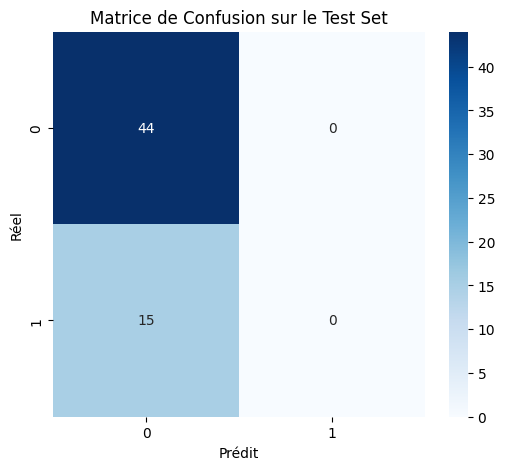

Rapport de classification :

              precision    recall  f1-score   support

           0       0.75      1.00      0.85        44
           1       0.00      0.00      0.00        15

    accuracy                           0.75        59
   macro avg       0.37      0.50      0.43        59
weighted avg       0.56      0.75      0.64        59



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [48]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Prédictions finales après entraînement
model.eval()
with torch.no_grad():
    logits = model(data.x, data.edge_index)
    preds = logits.argmax(dim=1).cpu().numpy()
    true_labels = data.y.cpu().numpy()

# Sélectionner uniquement les noeuds de test
test_preds = preds[data.test_mask.cpu().numpy()]
test_labels = true_labels[data.test_mask.cpu().numpy()]

# 📊 Matrice de confusion
cm = confusion_matrix(test_labels, test_preds)
df_cm = pd.DataFrame(cm, index=sorted(set(test_labels)), columns=sorted(set(test_labels)))

plt.figure(figsize=(6, 5))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de Confusion sur le Test Set")
plt.show()

# 📝 Rapport de classification (F1, Précision, Rappel)
print("Rapport de classification :\n")
print(classification_report(test_labels, test_preds))


**Classe 0 : très bien prédite.**

**Classe 1 : totalement ignorée (rappel = 0, précision = 0).
→ Cela indique un déséquilibre dans l'apprentissage du modèle.**

In [45]:
# 📌 Extraction des embeddings après entraînement
model.eval()
with torch.no_grad():
    node_embeddings = model(data.x, data.edge_index).cpu().numpy()


In [46]:

# --- Extraction des embeddings après entraînement du GNN ---

model.eval()
with torch.no_grad():
    node_embeddings = model(data.x, data.edge_index)

# --- PCA sur les embeddings ---
from sklearn.decomposition import PCA
import plotly.express as px

pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(node_embeddings.cpu().numpy())

# Vérification de la cohérence des classes
if hasattr(data, 'y'):
    labels = data.y.cpu().numpy()
else:
    labels = None

# Tracer avec Plotly
fig = px.scatter(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1],
                 color=labels,
                 title="Visualisation des embeddings de nœuds après GNN (PCA)",
                 labels={'x': 'PC1', 'y': 'PC2'})
fig.show()


# **Embeddings générés par le GCN :**

Chaque point représente un nœud du graphe, projeté dans un espace 2D (PC1, PC2) après apprentissage.

Ces embeddings sont censés capturer à la fois les attributs du nœud et la structure du graphe (voisinage, connexions, etc.)

# **Couleurs = classes réelles :**

Les points sont colorés par leur classe réelle (0, 1, ou 2 ici).

Cela permet de vérifier si le modèle a appris une représentation discriminante, c’est-à-dire si les nœuds appartenant à une même classe se regroupent dans l’espace appris.

On observe certains regroupements partiels par couleur (notamment dans la zone en haut à gauche). -> Cela indique que le GCN a appris des représentations utiles pour distinguer certaines classes.

Le fait que les embeddings ne soient pas totalement mélangés est bon signe : le modèle encode bien l’information de classe dans les représentations.

**Cependant il y a encore beaucoup de chevauchement entre classes**

**Faut peut etre améliorer le modèle avec plus de couches, autre architecture, features plus discriminantes? ou encore des classes déséquilibrées ou bruitées dans bitc_classes.csv**

**L’échelle de la première composante principale PC1 (variant de -40M à 90M) est très large -> Cela indique des valeurs extrêmes dans les embeddings, ce qui peut venir d’une absence de normalisation des features à l’entrée.**

**=> Un passage par StandardScaler ou MinMaxScaler avant d’entraîner le GCN pourrait stabiliser l’apprentissage et améliorer la séparation**


# **Améliorations :**
Le modèle favorise massivement la classe majoritaire (0).

Aucune capacité de généralisation sur la classe 1 → ce qui peut être dû à :

- Un déséquilibre important des classes dans les données.

- Une quantité insuffisante d’exemples pour la classe 1.

- Le modèle n'arrive pas à extraire des motifs discriminants pour cette classe.

**=> Essayer un modèle plus profond (ajouter une 3e couche) ou utiliser un autre GNN (GraphSAGE, GAT, ...)**

**=> Utiliser torch.utils.data.WeightedRandomSampler ou ajuster les poids de classe dans la loss pour équilibrer les classes**

**=>Oversampling (SMOTE) ou Undersampling dans le prétraitement**

**=> Visualiser les embeddings séparément pour chaque classe**


